* Date: The date of the recorded data.
* Open: The opening price of Bitcoin on that date.
* High: The highest price of Bitcoin on that date.
* Low: The lowest price of Bitcoin on that date.
* Close: The closing price of Bitcoin on that date.
* Adj Close: The adjusted closing price of Bitcoin, accounting for factors like splits or dividends (though dividends are irrelevant for Bitcoin).
* Volume: The trading volume of Bitcoin for that date.

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/content/bitcoin.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [3]:
df.shape

(2713, 7)

In [4]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2713.000000,2713.000000,2713.000000,2713.000000,2713.000000,2.713000e+03
mean,11311.041069,11614.292482,10975.555057,11323.914637,11323.914637,1.470462e+10
std,16106.428891,16537.390649,15608.572560,16110.365010,16110.365010,2.001627e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,606.396973,609.260986,604.109985,606.718994,606.718994,7.991080e+07
50%,6301.569824,6434.617676,6214.220215,6317.609863,6317.609863,5.098183e+09
75%,10452.399414,10762.644531,10202.387695,10462.259766,10462.259766,2.456992e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2713 entries, 0 to 2712
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2713 non-null   object 
 1   Open       2713 non-null   float64
 2   High       2713 non-null   float64
 3   Low        2713 non-null   float64
 4   Close      2713 non-null   float64
 5   Adj Close  2713 non-null   float64
 6   Volume     2713 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 148.5+ KB


### EDA

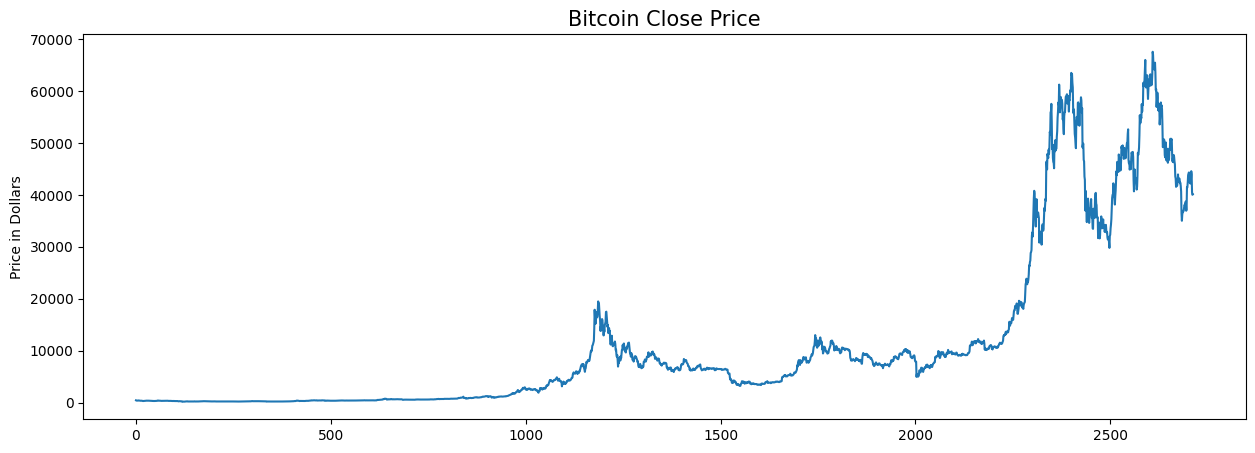

In [6]:
plt.figure(figsize=(15,5))
plt.plot(df['Close'])
plt.title('Bitcoin Close Price', fontsize=15)
plt.ylabel('Price in Dollars')
plt.show()

The closing price is showing an upward trend.

In [7]:
check = (df['Close'] == df['Adj Close'])
check.unique()

array([ True])

Here we are checking if the Close and Adj Close is same.
We found that it is same and we can drop of the columns

In [8]:
df.drop(columns='Adj Close', inplace=True, axis=1)  #Adj Close is dropped

In [9]:
df.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0


Checking for any null values.
No null values we can move on to further process.

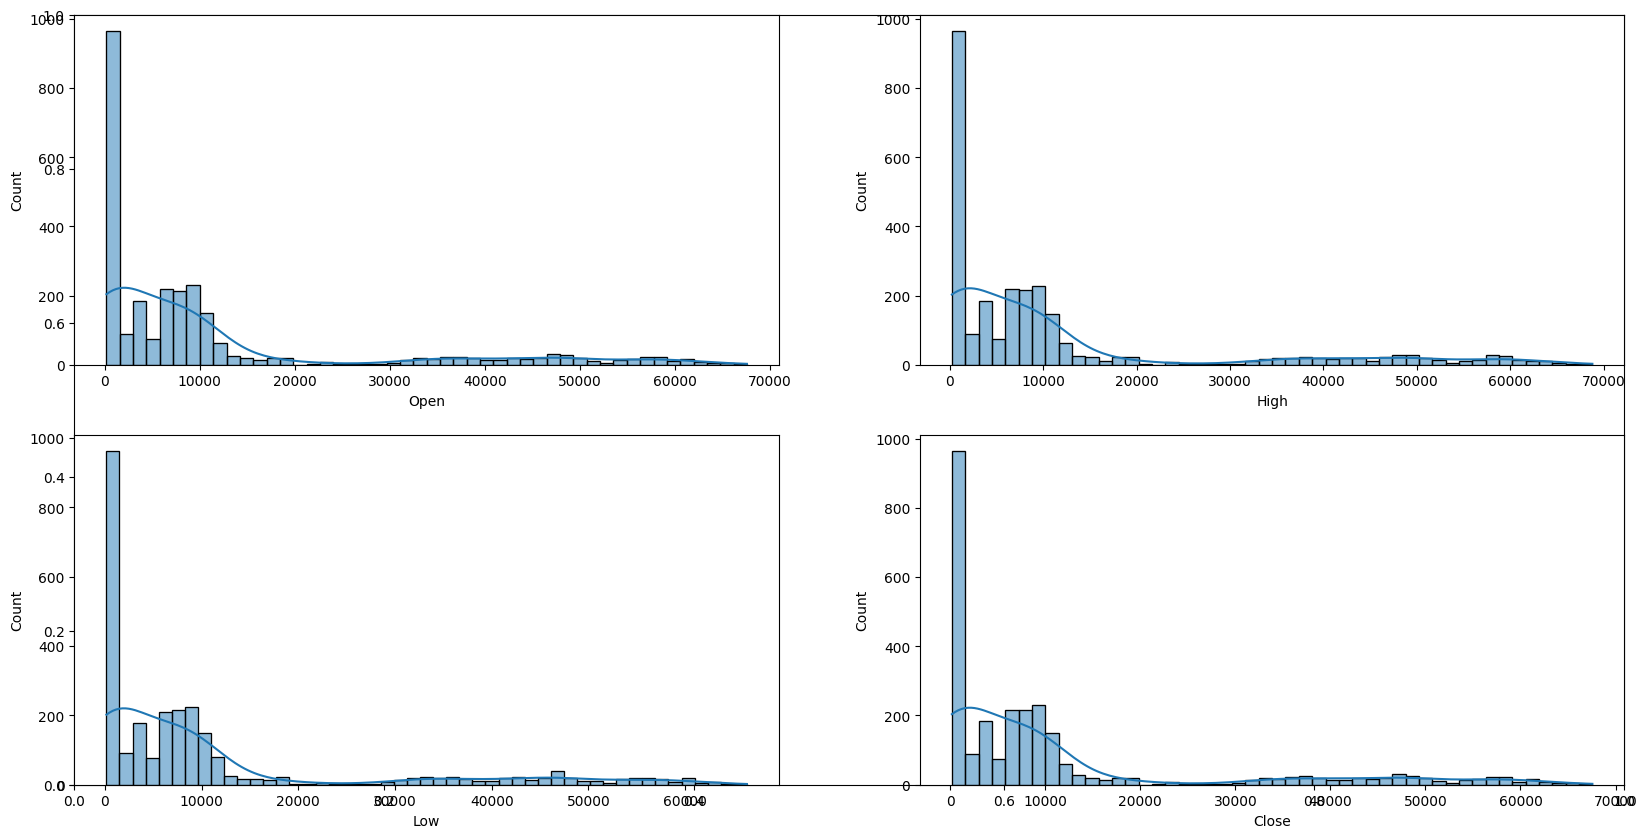

In [10]:
features = ['Open',"High","Low","Close"]

plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,2,i+1)
  sns.histplot(df[col], kde=True)
plt.show()

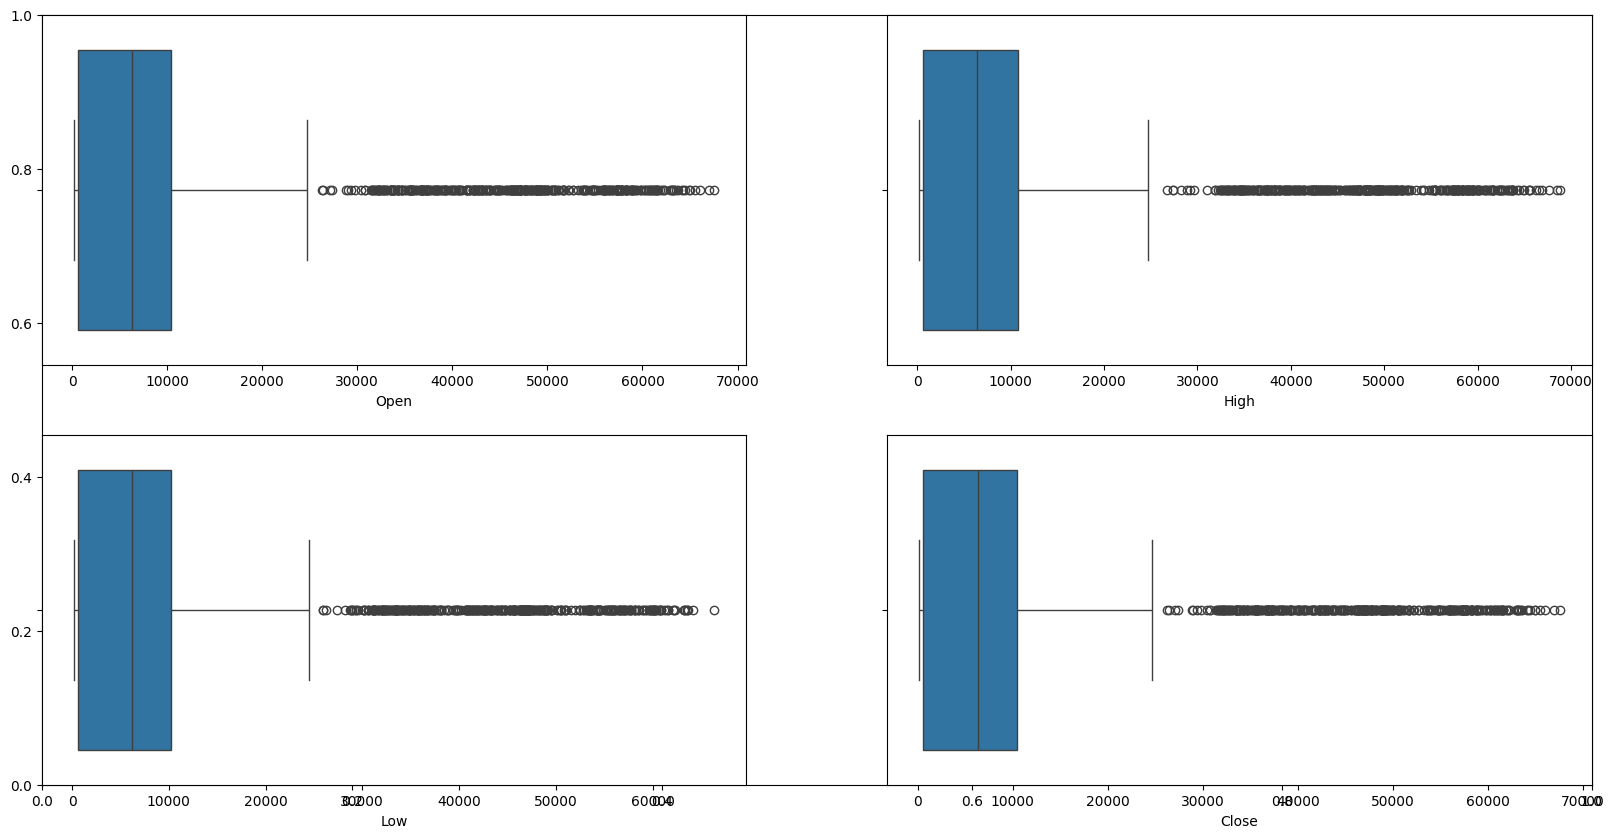

In [11]:
plt.subplots(figsize=(20, 10))
for i, col in enumerate(features):
  plt.subplot(2,2,i+1)
  sns.boxplot(x=df[col])
plt.show()

From this we can infer that there are a lot of outliers in each columns meaning the data hugely varied in a short period of time.

We can further understand this with the help of barplot.

In [12]:
# Convert the 'Date' column to datetime objects and extract year, month, and day
df['Date'] = pd.to_datetime(df['Date'])
df['year'], df['month'], df['day'] = df['Date'].dt.year, df['Date'].dt.month, df['Date'].dt.day

df.head()

,Date,Open,High,Low,Close,Volume,year,month,day
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,2014,9,17
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,2014,9,18
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,2014,9,19
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,2014,9,20
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,2014,9,21


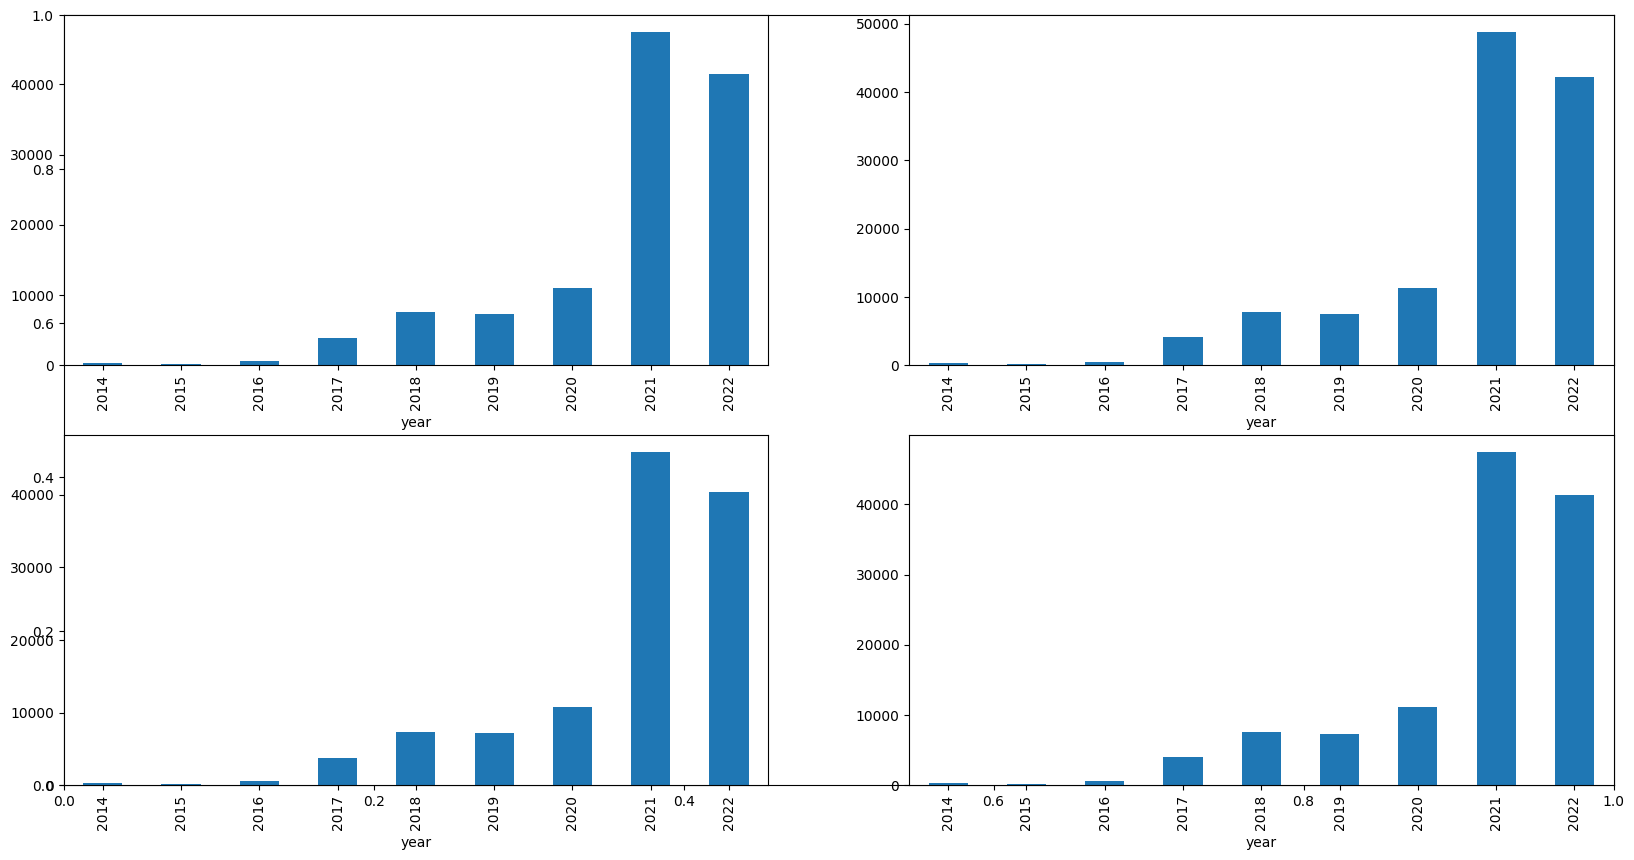

In [13]:
data_grouped = df.groupby('year').mean()
plt.subplots(figsize=(20,10))
for i, col in enumerate(['Open','High','Low','Close']):
    plt.subplot(2, 2, i+1)
    data_grouped[col].plot.bar()
plt.show()

We infer that the prices of bitcoins has exploded in the year 2021.

In [25]:
df['is_quarter_end'] = np.where(df['month']%3 == 0, 1, 0)
df.head()

,Date,Open,High,Low,Close,Volume,year,month,day,is_quarte_end,open-close,low-high,target,is_quarter_end
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,2014,9,17,1,8.529999,-15.752014,0,1
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,2014,9,18,1,32.419983,-43.755981,0,1
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,2014,9,19,1,29.307007,-43.302978,1,1
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,2014,9,20,1,-14.230988,-33.412994,0,1
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,2014,9,21,1,9.263977,-19.244995,1,1


In [26]:
df['open-close'] = df['Open'] - df['Close']
df['low-high'] = df['Low'] - df['High']
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

Added these new columns for our ML models.

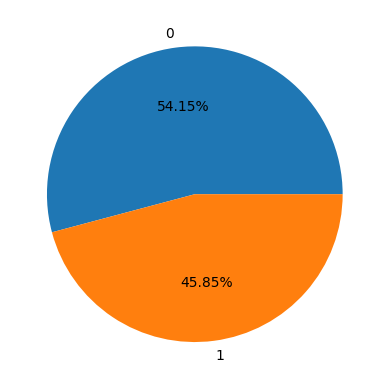

In [27]:
plt.pie(df['target'].value_counts().values, labels=[0,1], autopct='%1.2f%%')
plt.show()

Now we need to ensure that there are no highly correlated columns.

<Axes: >

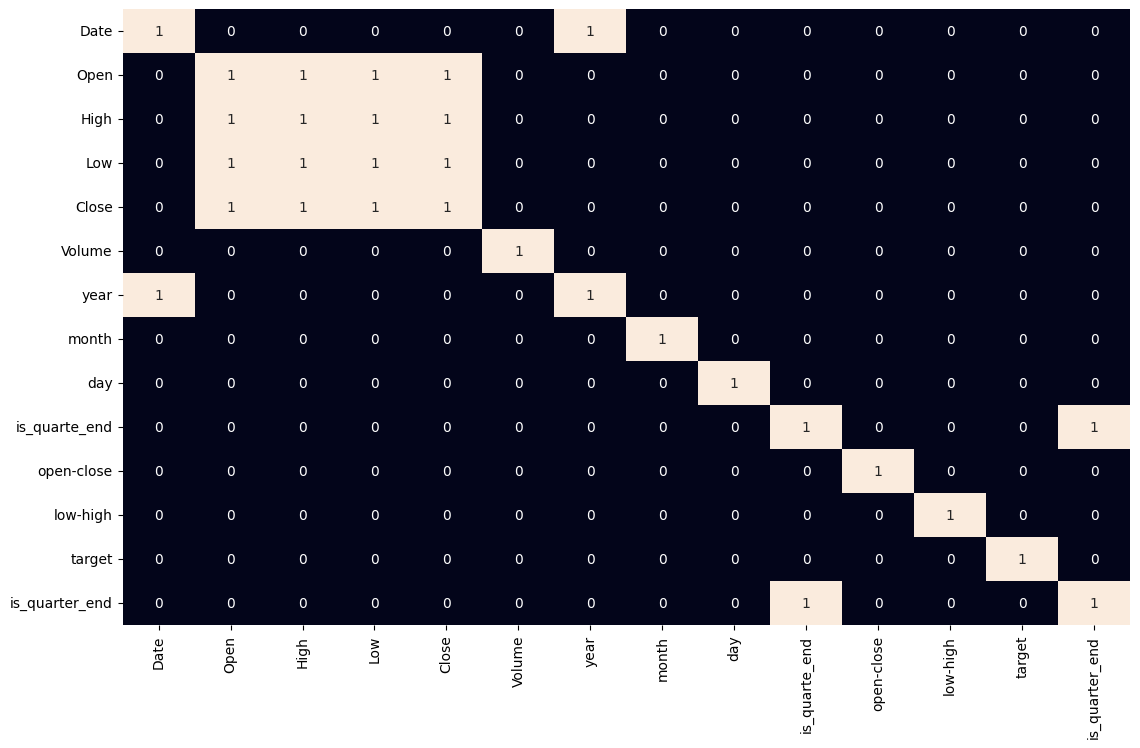

In [28]:
plt.figure(figsize=(13,8))
sns.heatmap(df.corr()>0.9, annot=True, cbar=False)

Here we see OHLC columns are highly correlated which is obvious and the columns which we added are not so correlated so we are good to go for further process.

---

EDA 2

In [33]:
x = df[['open-close','low-high','is_quarter_end']]
y = df['target']

scaler = StandardScaler()
x = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=420)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2441, 3), (272, 3), (2441,), (272,))

In [35]:
models = [LogisticRegression(), SVC(kernel='poly',probability=True), XGBClassifier()]

for i in range(3):
  models[i].fit(x_train, y_train)
  print(f'{models[i].__class__.__name__}')
  print('Training Accuracy : ', metrics.roc_auc_score(y_train, models[i].predict_proba(x_train)[:,1]))
  print('Test Accuracy : ', metrics.roc_auc_score(y_test, models[i].predict_proba(x_test)[:,1]))
  print()

LogisticRegression
Training Accuracy :  0.5249534397836959
Test Accuracy :  0.5148056244830439

SVC
Training Accuracy :  0.4758974068086635
Test Accuracy :  0.4960573476702509

XGBClassifier
Training Accuracy :  0.9228538745257879
Test Accuracy :  0.449793217535153



Among 3 models, we see only LR model to be a bit stable.
XGB is tend to overfit.

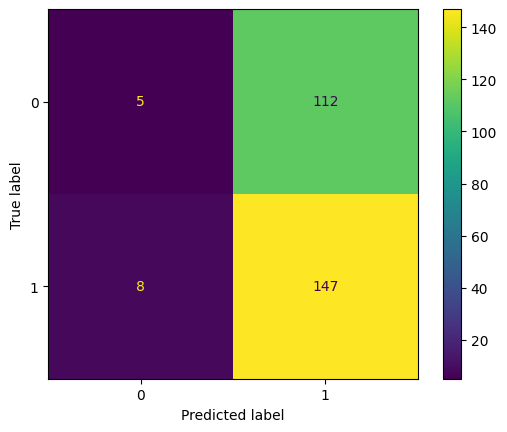

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(models[0],x_test,y_test)
plt.show()

We can observe that the accuracy achieved by the model is no better than simply guessing the probability of 50%.

Thank you so much for going through my work till the end, feel free to get in touch if you have any doubts... :)